In [1]:
import torch
import cv2
import onnxruntime as ort
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from utils.util import full_frame_preprocess, full_frame_postprocess, crop_roi_image
from utils.box_utils import predict

# scale current rectangle to box
def scale(box):
    width = box[2] - box[0]
    height = box[3] - box[1]
    maximum = max(width, height)
    dx = int((maximum - width)/2)
    dy = int((maximum - height)/2)

    bboxes = [box[0] - dx, box[1] - dy, box[2] + dx, box[3] + dy]
    return bboxes

# crop image
def cropImage(image, box):
    num = image[box[1]:box[3], box[0]:box[2]]
    return num


def letterbox(im, new_shape=(320, 320), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    """_summary_

    Args:
        im (_type_): _description_
        new_shape (tuple, optional): _description_. Defaults to (320, 320).
        color (tuple, optional): _description_. Defaults to (114, 114, 114).
        auto (bool, optional): _description_. Defaults to True.
        scaleup (bool, optional): _description_. Defaults to True.
        stride (int, optional): _description_. Defaults to 32.

    Returns:
        _type_: _description_
    """
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

c:\Users\User\miniconda3\envs\fyp\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# https://github.com/onnx/models/tree/main/validated/vision/body_analysis/ultraface#dataset
weight_path = "data/model_weights/version-RFB-640.onnx"
provider = ['CPUExecutionProvider']
category = "angry"
threshold = 0.5

In [3]:
session = ort.InferenceSession(weight_path, providers=provider)

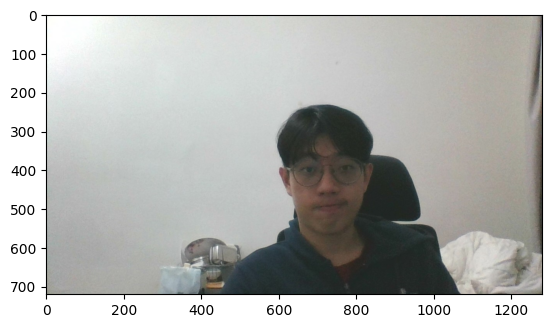

In [4]:
image_file = os.listdir(f"data/train/{category}/")[3]
image = cv2.imread(f"data/train/{category}/{image_file}")

# manual read image 
image = cv2.imread(f"data/face_detection/WIN_20240207_02_31_56_Pro.jpg")
#show image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [5]:
outname=[i.name for i in session.get_outputs()]
# image_output, ratio, dwdh = full_frame_preprocess(image, new_shape=(112,112), auto=False)

In [6]:
original_image = image.copy()
image = cv2.resize(image, (640, 480))
image_mean = np.array([127, 127, 127])
image = (image - image_mean) / 128
image = np.transpose(image, [2, 0, 1])
image = np.expand_dims(image, axis=0)
image = image.astype(np.float32)

In [7]:
original_image.shape

(720, 1280, 3)

(1, 4)


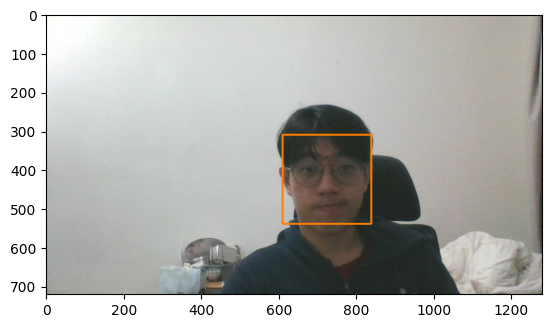

In [8]:
# set bbox color
color = (255, 128, 0)

confidences, bboxes = session.run(None, {session.get_inputs()[0].name: image})
boxes, labels, probs = predict(original_image.shape[1], original_image.shape[0], confidences, bboxes, threshold)
print(boxes.shape)
for i in range(boxes.shape[0]):
    box = scale(boxes[i, :])
    cv2.rectangle(original_image, (box[0], box[1]), (box[2], box[3]), color, 4)
    plt.imshow(original_image)
    break

# out = session.run(outname, {'data': image_output/255})[0]
# bbox, score = full_frame_postprocess(out, ratio, dwdh, threshold)
# cropped_image = crop_roi_image(image, bbox, (224, 224))
# # x1, y1, x2, y2 = bbox
# # crop_image = image[y1:y2, x1:x2]
# plt.imshow(cropped_image)

(229, 229, 3)


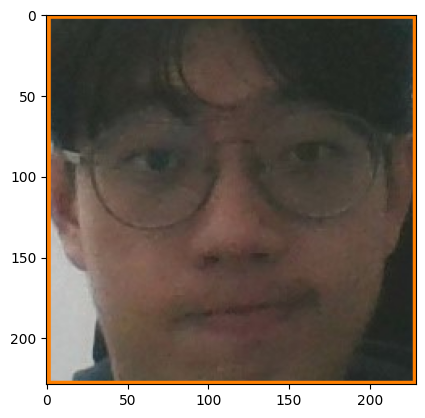

In [13]:
cropped_image = original_image[box[1]:box[3], box[0]:box[2]]
print(cropped_image.shape)
plt.imshow(cropped_image)

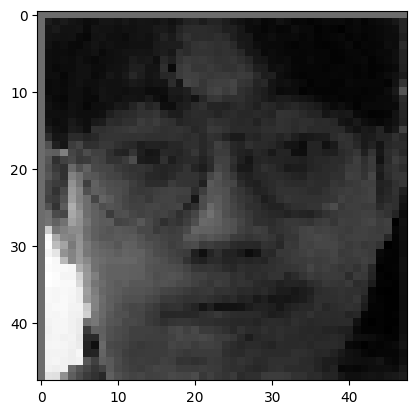

In [14]:
# resize cropped image to 48x48x1
cropped_image = cv2.resize(cropped_image, (48, 48))
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)

plt.imshow(cropped_image, cmap='gray')